In [35]:
import os
import pandas as pd
import numpy as np
import skimage
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import keras
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input,  GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split


In [36]:
drive.mount('/drive')


Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [37]:
path= "/drive/MyDrive/malaria_hematie_dataset"

In [38]:
parasitized_folder_path = os.path.join(path, "parasitized")
uninfected_folder_path = os.path.join(path, "uninfected")
images_array = np.zeros(shape=(28000, 128, 128))

In [5]:
if not os.path.exists(parasitized_folder_path):
    raise FileNotFoundError(f"Path not found: {parasitized_folder_path}")
if not os.path.exists(uninfected_folder_path):
    raise FileNotFoundError(f"Path not found: {uninfected_folder_path}")

In [7]:
def load_data(data_dir):
    images = []
    labels = []

    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        if not os.path.isdir(folder_path):
            continue  # Skip if not a directory
        label = folder
        for file in os.listdir(folder_path):
            try:
                image_path = os.path.join(folder_path, file)
                image = Image.open(image_path)
                image = image.convert('L')  # Convert image to grayscale
                img_resized = image.resize((128, 128))
                image_array = np.array(img_resized)
                images.append(image_array)
                labels.append(label)
            except Exception as e:
                print(f"Error reading {image_path}: {str(e)}")

    images = np.array(images)
    labels = np.array(labels)
    return images, labels





In [8]:
images_array, labels = load_data(path)

(-0.5, 127.5, 127.5, -0.5)

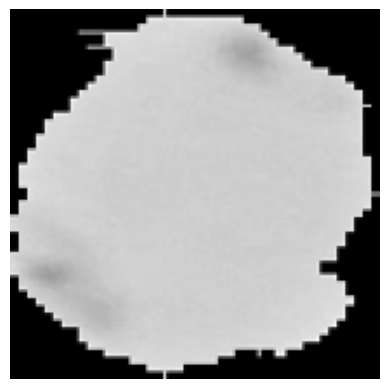

In [9]:
plt.imshow(images_array[13900], cmap="gray")
plt.axis('off')

Normalisation

In [10]:
images_array = preprocess_input(images_array * 255.0)


Encodage

In [11]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [13]:
#augmenter la dimension des images pour étendre la dimension du tableau pour le padding
images_array = np.expand_dims(images_array, axis=-1)


Data augmentation

In [14]:
# Supprimer la dimension supplémentaire de images_array
images_array = np.squeeze(images_array, axis=-1)

# Vérifier les dimensions après avoir supprimé la dimension supplémentaire
print("New shape of images_array:", images_array.shape)

# Diviser les données en ensembles d'entraînement et de test
train_images_array, test_images_array, train_labels_array, test_labels_array = train_test_split(
images_array, labels_encoded, test_size=0.2, random_state=42)

# Afficher les tailles des ensembles d'entraînement et de test
print("Size of train set:", len(train_images_array))
print("Size of test set:", len(test_images_array))


New shape of images_array: (27441, 128, 128, 1)
Size of train set: 21952
Size of test set: 5489


In [15]:
data_augmentation_generator= ImageDataGenerator(
    validation_split=0.2,  # Fraction des données à utiliser pour la validation
    rotation_range=20,  # Rotation aléatoire des images
    shear_range=0.2,  # Cisaillement aléatoire
    zoom_range=0.2,  # Zoom aléatoire
    horizontal_flip=True,  # Flip horizontal aléatoire
)

#Diviser en train et en test avant l'augmentation pour empecher que le modèle ne soit en overfit

#data augmentation
images_train_generator = data_augmentation_generator.flow(train_images_array,train_labels_array, batch_size=16, subset="training", seed=7)
print(len(images_train_generator))
images_val_generator = data_augmentation_generator.flow(train_images_array, train_labels_array, batch_size=16, subset="training", seed=7)


1098


ValueError: Found input variables with inconsistent numbers of samples: [1, 27441]

Shape of images_array: (1, 27441, 128, 128)
Value of split_index: 0
First few images in images_array:
[[[[-103.939 -116.779 -123.68  ...    0.       0.       0.   ]
   [-103.939 -116.779 -123.68  ...    0.       0.       0.   ]
   [-103.939 -116.779 -123.68  ...    0.       0.       0.   ]
   ...
   [-103.939 -116.779 -123.68  ...    0.       0.       0.   ]
   [-103.939 -116.779 -123.68  ...    0.       0.       0.   ]
   [-103.939 -116.779 -123.68  ...    0.       0.       0.   ]]

  [[-103.939 -116.779 -123.68  ...    0.       0.       0.   ]
   [-103.939 -116.779 -123.68  ...    0.       0.       0.   ]
   [-103.939 -116.779 -123.68  ...    0.       0.       0.   ]
   ...
   [-103.939 -116.779 -123.68  ...    0.       0.       0.   ]
   [-103.939 -116.779 -123.68  ...    0.       0.       0.   ]
   [-103.939 -116.779 -123.68  ...    0.       0.       0.   ]]

  [[-103.939 -116.779 -123.68  ...    0.       0.       0.   ]
   [-103.939 -116.779 -123.68  ...    0.       0.       0.   

Size of train set: 0
Size of test set: 1


Affichage des images

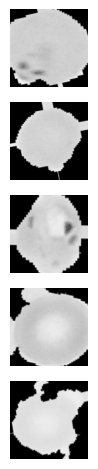

In [17]:
num_images_to_show = 5

# Afficher quelques images générées
for i in range(num_images_to_show):
    # Extraire un lot d'images générées
    try:
        images_batch,_ = next(images_train_generator)  # images_batch contient les images, _ contient les labels
        if images_batch.shape[0] == 0:
            print("Batch is empty.")
            continue

        # Afficher les images
        plt.subplot(num_images_to_show, 1, i+1)
        plt.imshow(images_batch[0], cmap="gray")  # Afficher la première image du lot
        plt.axis('off')
    except Exception as e:
        print(f"Error: {str(e)}")

plt.tight_layout()
plt.show()

TypeError: Invalid shape (27441, 128, 128) for image data

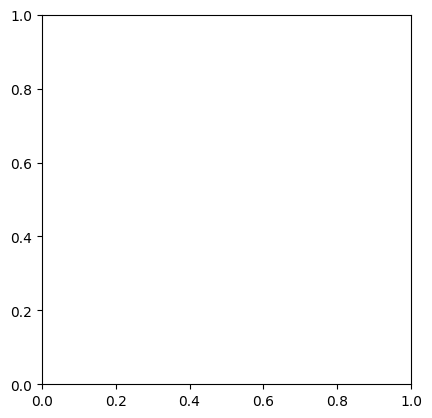

Model

In [18]:

# Définir le callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',    # Surveiller la perte de validation
    patience=5,            # Nombre d'époques avec amélioration de la validation avant d'arrêter l'entraînement
    verbose=1,             # Afficher les messages d'arrêt
    restore_best_weights=True  # Restaurer les poids du meilleur modèle après l'arrêt
)

# Définir le callback ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Surveiller la perte de validation
    factor=0.1,            # Facteur par lequel le taux d'apprentissage sera réduit
    patience=3,            # Nombre d'époques avec amélioration de la validation avant de réduire le taux d'apprentissage
    verbose=1,             # Afficher les messages de réduction du taux d'apprentissage
    min_lr=1e-6            # Taux d'apprentissage minimum
)

# Inclure les callbacks dans l'entraînement du modèle
callbacks = [early_stopping, reduce_lr]




Implémentation de 3 CNN pour la Labelisation à l'aide de Keras


In [19]:
#Modèle from scratch avec Sequential
model_sequentiel = keras.Sequential(
  [
      # Feature learning ~ Encoder
      keras.Input(shape=(224, 224, 1)),
      keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
      keras.layers.MaxPooling2D(pool_size=(2,2)),

      keras.layers.Dropout(0.3),

      keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
      keras.layers.MaxPooling2D(pool_size=(2,2)),

      keras.layers.Dropout(0.3),

      # connexion encoder <-> classifier
      keras.layers.Flatten(),

      # Classifier ~ Fully connected
      keras.layers.Dense(128, activation="relu")

  ]
)
model_sequentiel.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0

Fine-tuning du VGG16 pré-entraîné sur ImageNet :
Récupérez l'encodeur pré-entraîné et ajoutez des couches Dense pour l'adaptation finale.
Utilisez la même normalisation dans le pré-traitement des données que celle utilisée lors de l'entraînement initial sur ImageNet.



In [20]:
model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


58889256/58889256 [==============================] - 0s 0us/step


In [21]:
x = model_vgg16.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Ajoutez un Dropout pour éviter l'overfitting
predictions = Dense(1, activation='sigmoid')(x)  # Utilisez 'sigmoid' si vous avez une seule classe

model_vgg16 = Model(inputs=model_vgg16.input, outputs=predictions)


Fine-tuning du ResNet50 pré-entraîné sur ImageNet :
Suivez une démarche similaire à celle du VGG16.


In [22]:
model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128,3))


94765736/94765736 [==============================] - 1s 0us/step


In [23]:
x = model_resnet50.output
x = GlobalAveragePooling2D()(x)  # Utilisez GlobalAveragePooling2D à la place de Flatten pour ResNet50
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Ajoutez un Dropout pour éviter l'overfitting
predictions = Dense(1, activation='sigmoid')(x)  # Utilisez 'sigmoid' si vous avez une seule classe

model_resnet50 = Model(inputs=model_resnet50.input, outputs=predictions)


Entrainement des models

In [24]:
scheduler= lambda epoch, current_lr : current_lr * math.exp(-0.1*epoch) if current_lr > 10**(-4) else 10**(-4)
learning_rate_decay = keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = early_stopping

In [30]:
optimizer = 'adam'



In [31]:
def entrainement (model):
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  history = model.fit(
      images_train_generator,
      validation_data=images_val_generator,
      epochs=1000,
      callbacks=callbacks,
      steps_per_epoch=len(images_train_generator),
      validation_steps=len(images_val_generator)
  )


## Entrainement des models

In [32]:
model_sequentiel.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model_sequentiel.fit(
    images_train_generator,
    validation_data=images_val_generator,
    epochs=1000,
    callbacks=callbacks,

    validation_steps=len(images_val_generator)
)


Epoch 1/1000


InvalidArgumentError: Graph execution error:

Detected at node sequential/dense/Relu defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-32-63dac1e20761>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py", line 255, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/activations.py", line 306, in relu

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5395, in relu

Matrix size-incompatible: In[0]: [16,65536], In[1]: [200704,128]
	 [[{{node sequential/dense/Relu}}]] [Op:__inference_train_function_8307]

In [33]:
model_vgg16.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model_vgg16.fit(
    images_train_generator,
    validation_data=images_val_generator,
    epochs=1000,
    callbacks=callbacks,

    validation_steps=len(images_val_generator)
)


Epoch 1/1000


InvalidArgumentError: Graph execution error:

Detected at node model/block1_conv1/Relu defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-33-abc3f6f327aa>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/activations.py", line 306, in relu

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5395, in relu

input depth must be evenly divisible by filter depth: 1 vs 3
	 [[{{node model/block1_conv1/Relu}}]] [Op:__inference_train_function_11698]

In [ ]:
history2 = entrainement(model=model_vgg16)

In [ ]:
history3 = entrainement(model=model_resnet50)

In [34]:
model_resnet50.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model_resnet50.fit(
    images_train_generator,
    validation_data=images_val_generator,
    epochs=1000,
    callbacks=callbacks,

    validation_steps=len(images_val_generator)
)


Epoch 1/1000


InvalidArgumentError: Graph execution error:

Detected at node model_1/conv1_conv/BiasAdd defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-34-fd806e9e4ef1>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 311, in call

input depth must be evenly divisible by filter depth: 1 vs 3
	 [[{{node model_1/conv1_conv/BiasAdd}}]] [Op:__inference_train_function_34817]

## Sauvegarde

In [ ]:
from google.colab import files
history1.save("model_sequentiel.h5")
files.download("model_sequentiel.h5")

history2.save("model_vgg16.h5")
files.download("model_vgg16.h5")

history3.save("model_resnet50.h5")
files.download("model_resnet50.h5")

## Test des Modèles

### Calculer la Matrice de Confusion

In [ ]:
def confusion_matrice(model):
  Y_pred = model.predict(test_generator)
  y_pred = np.argmax(Y_pred, axis=1)
  return confusion_matrix(y_true, y_pred)


In [ ]:
print('model sequentiel : ', confusion_matrice(model_sequentiel))
print("model vgg16 : " , confusion_matrice(model_vgg16) )
print("model resnet50 : ",confusion_matrice(model_resnet50))

### Calculer les métriques de performance

### le graphique ROC et calculer l’AUC de chacun des 3 modèles.


In [ ]:
# Obtenir les probabilités prédictives pour chaque modèle
y_model_sequentiel = model_sequentiel.predict(test_images_array)
y_model_vgg16 = model_vgg16.predict(test_images_array)
y_model_resnet50 = model_resnet50.predict(test_images_array)

# Calculer les courbes ROC et les AUC pour chaque modèle
fpr1, tpr1, _ = roc_curve(test_labels_array, y_model_sequentiel)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(test_labels_array, y_model_vgg16
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(test_labels_array, y_model_resnet50
roc_auc3 = auc(fpr3, tpr3)

# Tracer les courbes ROC
plt.figure()
plt.plot(fpr1, tpr1, color='yellow', lw=2, label='Model Sequentiel (AUC = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, color='green', lw=2, label='Model vgg16 (AUC = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='red', lw=2, label='Model resnet50 (AUC = %0.2f)' % roc_auc3)

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonale de référence

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


## Interpretation

